In [1]:
import numpy as np
import pandas as pd

import math
from numpy.linalg import norm

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

import warnings
warnings.filterwarnings("ignore")

import re
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_excel('review.xlsx')
data.drop(['Unnamed: 13'], axis=1, inplace=True)
data.head()

,FDA_Chapter,FDA_Section,FDA_Code,FDA_Subpart,FDA_Description,matched,score,HC_Code,HC_Chapter,HC_Section,HC_Subpart,HC_Description,truth
0,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Buildings and Facilities,"""211.56""",Sanitation.,"(a) Any building used in the manufacture, proc...",1,0.773877,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y
1,CURRENT GOOD MANUFACTURING PRACTICE FOR TYPE A...,Construction and Maintenance of Facilities and...,"""226.20""",Buildings.,Buildings in which Type A medicated article(s)...,1,0.724563,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y
2,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Buildings and Facilities,"""211.58""",Maintenance.,"Any building used in the manufacture, processi...",1,0.717186,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y
3,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Equipment,"""211.63""","Equipment design, size, and location.","Equipment used in the manufacture, processing,...",1,0.742327,C.02.005,Drugs,Good Manufacturing Practices,Equipment,The equipment with which a lot or batch of a d...,Y
4,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Records and Reports,"""211.182""",Equipment cleaning and use log.,"A written record of major equipment cleaning, ...",1,0.628404,C.02.007,Drugs,Good Manufacturing Practices,Sanitation,(1) Every person who fabricates or packages/la...,Y


In [3]:
data_Interpretation= data.loc[data['HC_Subpart'] == 'Interpretation']
data_General = data.loc[data['HC_Subpart'] == 'General']
data_removal = pd.concat([data_Interpretation,data_General])
cond = data['HC_Subpart'].isin(data_removal['HC_Subpart'])
data.drop(data[cond].index, inplace = True)
data.reset_index(drop=True, inplace=True)

In [4]:
data['fda_desc_cleaned']=''
data['hc_desc_cleaned']=''

# Pre-processing FDA Descriptions
lemmatizer = WordNetLemmatizer()
pattern1 = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
pattern2 = '[0-9]'
for i in range(0,len(data)):
        sent_ref = data.iloc[i]['FDA_Description']
#         sent_ref = sent_ref.lower() # convert to lower case
        word_list = nltk.word_tokenize(sent_ref)
        sent_ref = ' '.join([lemmatizer.lemmatize(w) for w in word_list]) # lemmatize
        sent_ref = re.sub(r'\([^)]*\)', '', sent_ref) # remove characters which are within () and []
        sent_ref = pattern1.sub('', sent_ref) # remove stopwords
        sent_ref = re.sub(r'[^\w\s]','',sent_ref) # remove spaces (new line, tabs etc)
        sent_ref = re.sub(pattern2, '', sent_ref) # remove numbers
        sent_ref = " ".join(sent_ref.split()) # remove whitespaces, if any
        data['fda_desc_cleaned'][i] = sent_ref
        
# Pre-processing Health Canada Descriptions
lemmatizer = WordNetLemmatizer()
pattern1 = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
pattern2 = '[0-9]'
for i in range(0,len(data)):
        sent_ref = data.iloc[i]['HC_Description']
#         sent_ref = sent_ref.lower() # convert to lower case
        word_list = nltk.word_tokenize(sent_ref)
        sent_ref = ' '.join([lemmatizer.lemmatize(w) for w in word_list]) # lemmatize
        sent_ref = re.sub(r'\([^)]*\)', '', sent_ref) # remove characters which are within parenthesis
        sent_ref = pattern1.sub('', sent_ref) # remove stopwords
        sent_ref = re.sub(r'[^\w\s]','',sent_ref) # remove spaces (new line, tabs etc)
        sent_ref = re.sub(pattern2, '', sent_ref) # remove numbers
        sent_ref = " ".join(sent_ref.split()) # remove whitespaces, if any
        data['hc_desc_cleaned'][i] = sent_ref

In [5]:
def angular_distance(src, tgt):
    cos_sim = cosine_similarity(src, tgt)
    np.fill_diagonal(cos_sim, 1)
    distance = 1 - (np.arccos(cos_sim) / math.pi)
    return distance

def cosine_sim(src, tgt):
    similarity = cosine_similarity(src, tgt)
    return similarity


def manhattan_dist(src, tgt):
    distance = manhattan_distances(src, tgt)
    return distance


def euclidean_dist(src, tgt):
    distance = euclidean_distances(src, tgt)
    return distance

In [6]:
def theta(src, tgt):
    similarity_ = cosine_sim(src, tgt)
    np.fill_diagonal(similarity_, 1)
    theta_ = np.arccos(similarity_) + math.radians(10)
    return theta_


def magnitude_difference(src, tgt):
    src_len = len(src)
    src_norm = norm(src, axis=1).repeat(src_len).reshape(src_len, -1)
    tgt_norm = norm(tgt, axis=1)
    difference_ = np.abs(src_norm - tgt_norm)
    return difference_


def triangle_area_similarity(src, tgt, theta_):
    src_len = len(src)
    src_norm = norm(src, axis=1).repeat(src_len).reshape(src_len, -1)
    tgt_norm = norm(tgt, axis=1)
    triangle_similarity_ = (src_norm * tgt_norm * np.sin(theta_)) / 2
    return triangle_similarity_


def sector_area_similarity(src, tgt, theta_):
    distance_ = euclidean_dist(src, tgt)
    difference_ = magnitude_difference(src, tgt)
    sector_similarity_ = math.pi * ((distance_ + difference_) ** 2)
    sector_similarity_ *= theta_ / 360
    return sector_similarity_


def triangle_sector_similarity(src, tgt):
    theta_ = theta(src, tgt)
    triangle_similarity_ = triangle_area_similarity(src, tgt, theta_)
    sector_similarity_ = sector_area_similarity(src, tgt, theta_)
    ts_ss_ = triangle_similarity_ * sector_similarity_
    return ts_ss_

In [7]:
data['angular_distance'] = ''
data['cosine']=''
data['manhattan_distance']=''
data['euclidean_distance']=''
data['tss']=''

In [8]:
embedder = SentenceTransformer('distilbert-base-nli-mean-tokens')

for i in range(0,len(data)):
    sent1 = data['fda_desc_cleaned'][i]
    sent2 = data['hc_desc_cleaned'][i]
    enc_sentences = embedder.encode([sent1,sent2])
    data['angular_distance'][i] = angular_distance(enc_sentences[0:1],enc_sentences)[0,1]
    data['cosine'][i] = cosine_sim(enc_sentences[0:1],enc_sentences)[0,1]
    data['manhattan_distance'][i] = manhattan_dist(enc_sentences[0:1],enc_sentences)[0,1]
    data['euclidean_distance'][i] = euclidean_dist(enc_sentences[0:1],enc_sentences)[0,1]
    data['tss'][i] = triangle_sector_similarity(enc_sentences[0:1],enc_sentences)[0,1]

In [9]:
data.head()

,FDA_Chapter,FDA_Section,FDA_Code,FDA_Subpart,FDA_Description,matched,score,HC_Code,HC_Chapter,HC_Section,HC_Subpart,HC_Description,truth,fda_desc_cleaned,hc_desc_cleaned,angular_distance,cosine,manhattan_distance,euclidean_distance,tss
0,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Buildings and Facilities,"""211.56""",Sanitation.,"(a) Any building used in the manufacture, proc...",1,0.773877,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y,Any building used manufacture processing packi...,The premise lot batch drug fabricated packaged...,0.793936,0.797674,217.588,9.90447,67.3371
1,CURRENT GOOD MANUFACTURING PRACTICE FOR TYPE A...,Construction and Maintenance of Facilities and...,"""226.20""",Buildings.,Buildings in which Type A medicated article(s)...,1,0.724563,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y,Buildings Type A medicated article manufacture...,The premise lot batch drug fabricated packaged...,0.804923,0.81801,212.708,9.52794,56.0315
2,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Buildings and Facilities,"""211.58""",Maintenance.,"Any building used in the manufacture, processi...",1,0.717186,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y,Any building used manufacture processing packi...,The premise lot batch drug fabricated packaged...,0.811152,0.829109,207.85,9.41913,60.9247
3,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Equipment,"""211.63""","Equipment design, size, and location.","Equipment used in the manufacture, processing,...",1,0.742327,C.02.005,Drugs,Good Manufacturing Practices,Equipment,The equipment with which a lot or batch of a d...,Y,Equipment used manufacture processing packing ...,The equipment lot batch drug fabricated packag...,0.822018,0.847708,195.884,8.88377,49.1208
4,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Records and Reports,"""211.182""",Equipment cleaning and use log.,"A written record of major equipment cleaning, ...",1,0.628404,C.02.007,Drugs,Good Manufacturing Practices,Sanitation,(1) Every person who fabricates or packages/la...,Y,A written record major equipment cleaning main...,Every person fabricates packageslabels drug sh...,0.774437,0.759257,241.357,10.9657,101.482


#### angular distance

In [10]:
print(max(data.angular_distance))
print(min(data.angular_distance))

0.8736975
0.68753195


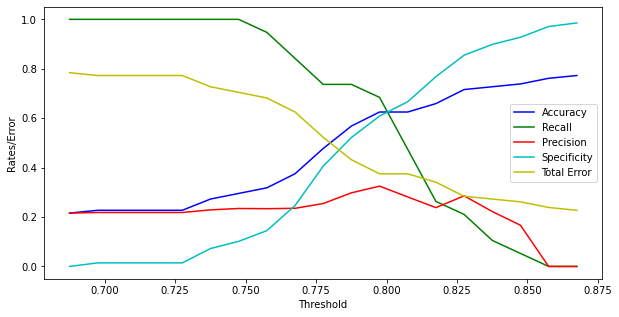

In [11]:
max_value = max(data.angular_distance)
min_value = min(data.angular_distance)

threshold = np.arange(min_value,max_value,0.01)

precision=[]
accuracy=[]
recall=[]
specificity=[]

for i in range(0,len(threshold)):
    data['y_pred'] = ''
    data['cm'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['angular_distance'][j] >= threshold[i]):
            data['y_pred'][j] = 'Y'
        else:
            data['y_pred'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'N'):
            data['cm'][k] = 'FN'
        else:
            data['cm'][k] = 'TN'
    
    
    tp = data.cm.value_counts().TP if 'TP' in data.cm.value_counts() is not None else 0
    tn = data.cm.value_counts().TN if 'TN' in data.cm.value_counts() is not None else 0
    fp = data.cm.value_counts().FP if 'FP' in data.cm.value_counts() is not None else 0
    fn = data.cm.value_counts().FN if 'FN' in data.cm.value_counts() is not None else 0

    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    precision.append(prec)
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    recall.append(rec)
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    specificity.append(spec)
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    accuracy.append(acc)

plt.figure(figsize=(10,5))

plt.plot(threshold, accuracy, color = 'b', label = 'Accuracy')
plt.plot(threshold, recall, color = 'g', label = 'Recall')
plt.plot(threshold, precision, color = 'r', label = 'Precision')
plt.plot(threshold, specificity, color = 'c', label = 'Specificity')
plt.plot(threshold, [1-x for x in accuracy], color = 'y', label = 'Total Error')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [50]:
threshold = np.arange(0.802,0.806,0.001)
results = pd.DataFrame(threshold,columns=['threshold'])
results['TP'] = ''
results['TN'] = ''
results['FP'] = ''
results['FN'] = ''

results['specificity'] = ''
results['recall']=''
results['precision']=''
results['accuracy']=''

for i in range(0,len(threshold)):
    threshold = results['threshold'][i]
    data['y_angular'] = ''
    data['cm_angular'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['angular_distance'][j] >= threshold):
            data['y_angular'][j] = 'Y'
        else:
            data['y_angular'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_angular'][k] == 'Y'):
            data['cm_angular'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_angular'][k] == 'Y'):
            data['cm_angular'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_angular'][k] == 'N'):
            data['cm_angular'][k] = 'FN'
        else:
            data['cm_angular'][k] = 'TN'
    
    
    tp = data.cm_angular.value_counts().TP if 'TP' in data.cm_angular.value_counts() is not None else 0
    results['TP'][i] = tp
    
    tn = data.cm_angular.value_counts().TN if 'TN' in data.cm_angular.value_counts() is not None else 0
    results['TN'][i] = tn
    
    fp = data.cm_angular.value_counts().FP if 'FP' in data.cm_angular.value_counts() is not None else 0
    results['FP'][i] = fp
    
    fn = data.cm_angular.value_counts().FN if 'FN' in data.cm_angular.value_counts() is not None else 0
    results['FN'][i] = fn
    
    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    results['precision'][i] = prec
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    results['recall'][i] = rec
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    results['accuracy'][i] = acc 
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    results['specificity'][i] = spec
    
print('-------- BERT: Angular Distance ----------')
results

-------- BERT: Angular Distance ----------


,threshold,TP,TN,FP,FN,specificity,recall,precision,accuracy
0,0.802,12,44,25,7,0.637681,0.631579,0.324324,0.636364
1,0.803,12,44,25,7,0.637681,0.631579,0.324324,0.636364
2,0.804,12,45,24,7,0.652174,0.631579,0.333333,0.647727
3,0.805,11,46,23,8,0.666667,0.578947,0.323529,0.647727
4,0.806,10,46,23,9,0.666667,0.526316,0.30303,0.636364


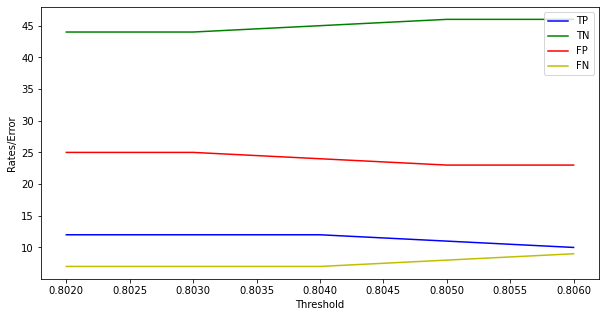

In [51]:
tp_list = results.TP.to_list()
tn_list = results.TN.to_list()
fp_list = results.FP.to_list()
fn_list = results.FN.to_list()

plt.figure(figsize=(10,5))

threshold = np.arange(0.802,0.806,0.001)

plt.plot(threshold,tp_list, color = 'b', label = 'TP')
plt.plot(threshold,tn_list, color = 'g', label = 'TN')
plt.plot(threshold,fp_list, color = 'r', label = 'FP')
plt.plot(threshold,fn_list, color = 'y', label = 'FN')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [52]:
data['y_angular']=''
for i in range(0,len(data)):
    if data['angular_distance'][i] >= 0.804:
        data['y_angular'][i] = 'Y'
    else:
        data['y_angular'][i] = 'N'
        
data['cm_angular']=''
for k in range(0,len(data)):
    if (data['truth'][k] == 'Y') and (data['y_angular'][k] == 'Y'):
        data['cm_angular'][k] = 'TP'
    elif (data['truth'][k] == 'N') and (data['y_angular'][k] == 'Y'):
        data['cm_angular'][k] = 'FP'
    elif (data['truth'][k] == 'Y') and (data['y_angular'][k] == 'N'):
        data['cm_angular'][k] = 'FN'
    else:
        data['cm_angular'][k] = 'TN'
        
tp = data.cm_angular.value_counts().TP if 'TP' in data.cm_angular.value_counts() is not None else 0
print('true positives:',tp)
tn = data.cm_angular.value_counts().TN if 'TN' in data.cm_angular.value_counts() is not None else 0
print('true negatives:',tn)
fp = data.cm_angular.value_counts().FP if 'FP' in data.cm_angular.value_counts() is not None else 0
print('false positives:',fp)
fn = data.cm_angular.value_counts().FN if 'FN' in data.cm_angular.value_counts() is not None else 0
print('false negatives:',fn)

precision = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
print('precision:',precision)
    
recall = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
print('recall:',recall)   

acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
print('accuracy:',acc)

true positives: 12
true negatives: 45
false positives: 24
false negatives: 7
precision: 0.3333333333333333
recall: 0.631578947368421
accuracy: 0.6477272727272727


#### manhattan

In [15]:
print(max(data.manhattan_distance))
print(min(data.manhattan_distance))

342.72436979511986
132.85637431946816


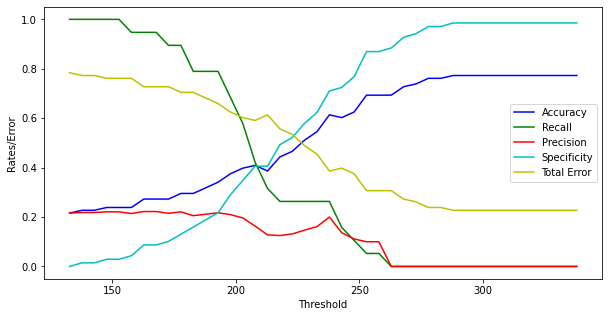

In [16]:
max_value = max(data.manhattan_distance)
min_value = min(data.manhattan_distance)
threshold = np.arange(min_value,max_value,5)

precision=[]
accuracy=[]
recall=[]
specificity=[]

for i in range(0,len(threshold)):
    data['y_pred'] = ''
    data['cm'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['manhattan_distance'][j] >= threshold[i]):
            data['y_pred'][j] = 'Y'
        else:
            data['y_pred'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'N'):
            data['cm'][k] = 'FN'
        else:
            data['cm'][k] = 'TN'
    
    
    tp = data.cm.value_counts().TP if 'TP' in data.cm.value_counts() is not None else 0
    tn = data.cm.value_counts().TN if 'TN' in data.cm.value_counts() is not None else 0
    fp = data.cm.value_counts().FP if 'FP' in data.cm.value_counts() is not None else 0
    fn = data.cm.value_counts().FN if 'FN' in data.cm.value_counts() is not None else 0

    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    precision.append(prec)
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    recall.append(rec)
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    accuracy.append(acc)
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    specificity.append(spec)

plt.figure(figsize=(10,5))

plt.plot(threshold, accuracy, color = 'b', label = 'Accuracy')
plt.plot(threshold, recall, color = 'g', label = 'Recall')
plt.plot(threshold, precision, color = 'r', label = 'Precision')
plt.plot(threshold, specificity, color = 'c', label = 'Specificity')
plt.plot(threshold, [1-x for x in accuracy], color = 'y', label = 'Total Error')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [41]:
threshold = np.arange(237,243,1)
results2 = pd.DataFrame(threshold,columns=['threshold'])
results2['TP'] = ''
results2['TN'] = ''
results2['FP'] = ''
results2['FN'] = ''

results2['specificity'] = ''
results2['recall']=''
results2['precision']=''
results2['accuracy']=''

for i in range(0,len(threshold)):
    threshold = results2['threshold'][i]
    data['y_manhattan'] = ''
    data['cm_manhattan'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['manhattan_distance'][j] >= threshold):
            data['y_manhattan'][j] = 'Y'
        else:
            data['y_manhattan'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_manhattan'][k] == 'Y'):
            data['cm_manhattan'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_manhattan'][k] == 'Y'):
            data['cm_manhattan'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_manhattan'][k] == 'N'):
            data['cm_manhattan'][k] = 'FN'
        else:
            data['cm_manhattan'][k] = 'TN'
    
    
    tp = data.cm_manhattan.value_counts().TP if 'TP' in data.cm_manhattan.value_counts() is not None else 0
    results2['TP'][i] = tp
    
    tn = data.cm_manhattan.value_counts().TN if 'TN' in data.cm_manhattan.value_counts() is not None else 0
    results2['TN'][i] = tn
    
    fp = data.cm_manhattan.value_counts().FP if 'FP' in data.cm_manhattan.value_counts() is not None else 0
    results2['FP'][i] = fp
    
    fn = data.cm_manhattan.value_counts().FN if 'FN' in data.cm_manhattan.value_counts() is not None else 0
    results2['FN'][i] = fn
    
    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    results2['precision'][i] = prec

    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    results2['recall'][i] = rec

    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    results2['accuracy'][i] = acc 
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    results2['specificity'][i] = spec
    

print('---------- BERT: Manhattan Distance ----------')
results2

---------- BERT: Manhattan Distance ----------


,threshold,TP,TN,FP,FN,specificity,recall,precision,accuracy
0,237,5,48,21,14,0.695652,0.263158,0.192308,0.602273
1,238,5,49,20,14,0.710145,0.263158,0.2,0.613636
2,239,5,49,20,14,0.710145,0.263158,0.2,0.613636
3,240,5,49,20,14,0.710145,0.263158,0.2,0.613636
4,241,5,49,20,14,0.710145,0.263158,0.2,0.613636
5,242,3,50,19,16,0.724638,0.157895,0.136364,0.602273


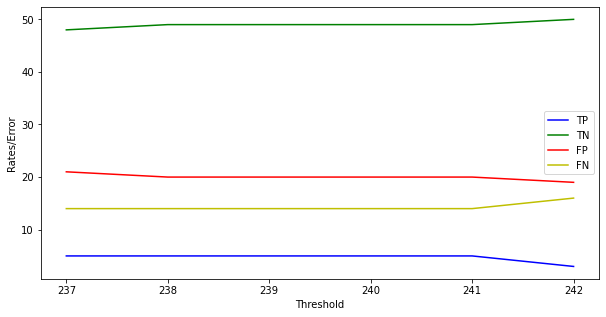

In [53]:
tp_list = results2.TP.to_list()
tn_list = results2.TN.to_list()
fp_list = results2.FP.to_list()
fn_list = results2.FN.to_list()

plt.figure(figsize=(10,5))

threshold = np.arange(237,243,1)

plt.plot(threshold,tp_list, color = 'b', label = 'TP')
plt.plot(threshold,tn_list, color = 'g', label = 'TN')
plt.plot(threshold,fp_list, color = 'r', label = 'FP')
plt.plot(threshold,fn_list, color = 'y', label = 'FN')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [54]:
data['y_manhattan']=''
for i in range(0,len(data)):
    if data['manhattan_distance'][i] >= 241:
        data['y_manhattan'][i] = 'Y'
    else:
        data['y_manhattan'][i] = 'N'
        
data['cm_manhattan']=''
for k in range(0,len(data)):
    if (data['truth'][k] == 'Y') and (data['y_manhattan'][k] == 'Y'):
        data['cm_manhattan'][k] = 'TP'
    elif (data['truth'][k] == 'N') and (data['y_manhattan'][k] == 'Y'):
        data['cm_manhattan'][k] = 'FP'
    elif (data['truth'][k] == 'Y') and (data['y_manhattan'][k] == 'N'):
        data['cm_manhattan'][k] = 'FN'
    else:
        data['cm_manhattan'][k] = 'TN'
        
tp = data.cm_manhattan.value_counts().TP if 'TP' in data.cm_manhattan.value_counts() is not None else 0
print('true positives:',tp)
tn = data.cm_manhattan.value_counts().TN if 'TN' in data.cm_manhattan.value_counts() is not None else 0
print('true negatives:',tn)
fp = data.cm_manhattan.value_counts().FP if 'FP' in data.cm_manhattan.value_counts() is not None else 0
print('false positives:',fp)
fn = data.cm_manhattan.value_counts().FN if 'FN' in data.cm_manhattan.value_counts() is not None else 0
print('false negatives:',fn)

precision = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
print('precision:',precision)

specificity = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
print('specificity:',specificity)
    
recall = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
print('recall:',recall)   

acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
print('accuracy:',acc)

true positives: 5
true negatives: 49
false positives: 20
false negatives: 14
precision: 0.2
specificity: 0.7101449275362319
recall: 0.2631578947368421
accuracy: 0.6136363636363636


#### euclidean

In [20]:
print(max(data.euclidean_distance))
print(min(data.euclidean_distance))

15.239647
6.025737


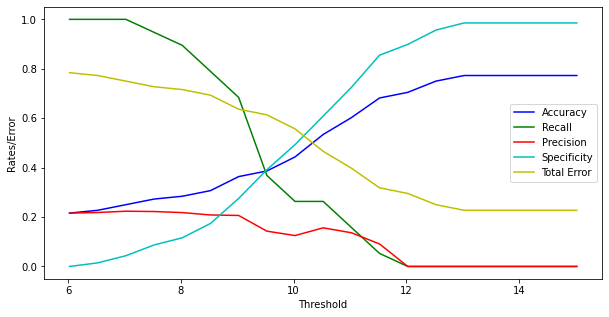

In [21]:
max_value = max(data.euclidean_distance)
min_value = min(data.euclidean_distance)
threshold = np.arange(min_value,max_value,0.5)

precision=[]
accuracy=[]
recall=[]
specificity=[]

for i in range(0,len(threshold)):
    data['y_pred'] = ''
    data['cm'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['euclidean_distance'][j] >= threshold[i]):
            data['y_pred'][j] = 'Y'
        else:
            data['y_pred'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'N'):
            data['cm'][k] = 'FN'
        else:
            data['cm'][k] = 'TN'
    
    
    tp = data.cm.value_counts().TP if 'TP' in data.cm.value_counts() is not None else 0
    tn = data.cm.value_counts().TN if 'TN' in data.cm.value_counts() is not None else 0
    fp = data.cm.value_counts().FP if 'FP' in data.cm.value_counts() is not None else 0
    fn = data.cm.value_counts().FN if 'FN' in data.cm.value_counts() is not None else 0

    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    precision.append(prec)
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    recall.append(rec)
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    accuracy.append(acc)
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    specificity.append(spec)

plt.figure(figsize=(10,5))

plt.plot(threshold, accuracy, color = 'b', label = 'Accuracy')
plt.plot(threshold, recall, color = 'g', label = 'Recall')
plt.plot(threshold, precision, color = 'r', label = 'Precision')
plt.plot(threshold, specificity, color = 'c', label = 'Specificity')
plt.plot(threshold, [1-x for x in accuracy], color = 'y', label = 'Total Error')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [42]:
threshold = np.arange(8.4,9,0.1)
results3 = pd.DataFrame(threshold,columns=['threshold'])
results3['TP'] = ''
results3['TN'] = ''
results3['FP'] = ''
results3['FN'] = ''

results3['specificity'] = ''
results3['recall']=''
results3['precision']=''
results3['accuracy']=''

for i in range(0,len(threshold)):
    threshold = results3['threshold'][i]
    data['y_euclid'] = ''
    data['cm_euclid'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['euclidean_distance'][j] >= threshold):
            data['y_euclid'][j] = 'Y'
        else:
            data['y_euclid'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_euclid'][k] == 'Y'):
            data['cm_euclid'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_euclid'][k] == 'Y'):
            data['cm_euclid'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_euclid'][k] == 'N'):
            data['cm_euclid'][k] = 'FN'
        else:
            data['cm_euclid'][k] = 'TN'
    
    
    tp = data.cm_euclid.value_counts().TP if 'TP' in data.cm_euclid.value_counts() is not None else 0
    results3['TP'][i] = tp
    
    tn = data.cm_euclid.value_counts().TN if 'TN' in data.cm_euclid.value_counts() is not None else 0
    results3['TN'][i] = tn
    
    fp = data.cm_euclid.value_counts().FP if 'FP' in data.cm_euclid.value_counts() is not None else 0
    results3['FP'][i] = fp
    
    fn = data.cm_euclid.value_counts().FN if 'FN' in data.cm_euclid.value_counts() is not None else 0
    results3['FN'][i] = fn
    
    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    results3['precision'][i] = prec

    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    results3['recall'][i] = rec

    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    results3['accuracy'][i] = acc 

    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    results3['specificity'][i] = spec
    
print('---------- BERT: Euclidean Distance ----------')
results3

---------- BERT: Euclidean Distance ----------


,threshold,TP,TN,FP,FN,specificity,recall,precision,accuracy
0,8.4,15,11,58,4,0.15942,0.789474,0.205479,0.295455
1,8.5,15,12,57,4,0.173913,0.789474,0.208333,0.306818
2,8.6,15,13,56,4,0.188406,0.789474,0.211268,0.318182
3,8.7,15,14,55,4,0.202899,0.789474,0.214286,0.329545
4,8.8,15,16,53,4,0.231884,0.789474,0.220588,0.352273
5,8.9,14,17,52,5,0.246377,0.736842,0.212121,0.352273


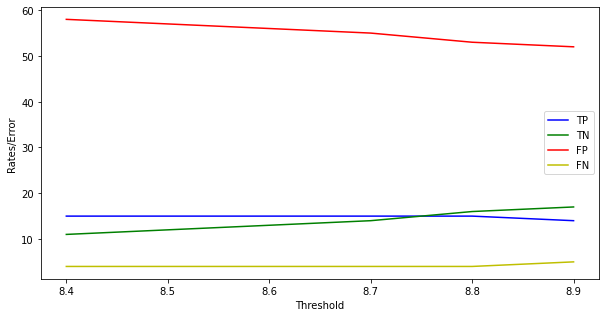

In [44]:
tp_list = results3.TP.to_list()
tn_list = results3.TN.to_list()
fp_list = results3.FP.to_list()
fn_list = results3.FN.to_list()

plt.figure(figsize=(10,5))

threshold = np.arange(8.4,9,0.1)

plt.plot(threshold,tp_list, color = 'b', label = 'TP')
plt.plot(threshold,tn_list, color = 'g', label = 'TN')
plt.plot(threshold,fp_list, color = 'r', label = 'FP')
plt.plot(threshold,fn_list, color = 'y', label = 'FN')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [45]:
data['y_euclid']=''
for i in range(0,len(data)):
    if data['euclidean_distance'][i] >= 8.8:
        data['y_euclid'][i] = 'Y'
    else:
        data['y_euclid'][i] = 'N'
        
data['cm_euclid']=''
for k in range(0,len(data)):
    if (data['truth'][k] == 'Y') and (data['y_euclid'][k] == 'Y'):
        data['cm_euclid'][k] = 'TP'
    elif (data['truth'][k] == 'N') and (data['y_euclid'][k] == 'Y'):
        data['cm_euclid'][k] = 'FP'
    elif (data['truth'][k] == 'Y') and (data['y_euclid'][k] == 'N'):
        data['cm_euclid'][k] = 'FN'
    else:
        data['cm_euclid'][k] = 'TN'
        
tp = data.cm_euclid.value_counts().TP if 'TP' in data.cm_euclid.value_counts() is not None else 0
print('true positives:',tp)
tn = data.cm_euclid.value_counts().TN if 'TN' in data.cm_euclid.value_counts() is not None else 0
print('true negatives:',tn)
fp = data.cm_euclid.value_counts().FP if 'FP' in data.cm_euclid.value_counts() is not None else 0
print('false positives:',fp)
fn = data.cm_euclid.value_counts().FN if 'FN' in data.cm_euclid.value_counts() is not None else 0
print('false negatives:',fn)

precision = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
print('precision:',precision)

specificity = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
print('specificity:',specificity)
    
recall = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
print('recall:',recall)   

acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
print('accuracy:',acc)

true positives: 15
true negatives: 16
false positives: 53
false negatives: 4
precision: 0.22058823529411764
specificity: 0.2318840579710145
recall: 0.7894736842105263
accuracy: 0.3522727272727273


#### ts-ss

In [25]:
print(max(data.tss))
print(min(data.tss))

300.48657
11.780301


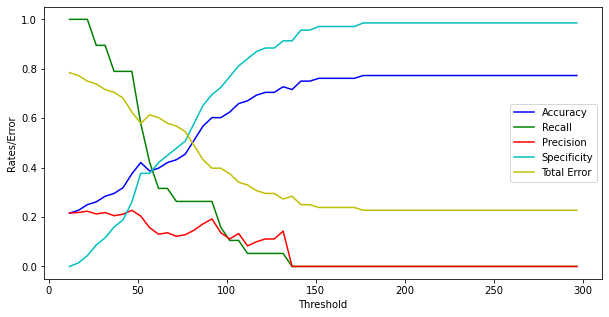

In [26]:
max_value = max(data.tss)
min_value = min(data.tss)
threshold = np.arange(min_value,max_value,5)

precision=[]
accuracy=[]
recall=[]
specificity=[]

for i in range(0,len(threshold)):
    data['y_pred'] = ''
    data['cm'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['tss'][j] >= threshold[i]):
            data['y_pred'][j] = 'Y'
        else:
            data['y_pred'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'N'):
            data['cm'][k] = 'FN'
        else:
            data['cm'][k] = 'TN'
    
    
    tp = data.cm.value_counts().TP if 'TP' in data.cm.value_counts() is not None else 0
    tn = data.cm.value_counts().TN if 'TN' in data.cm.value_counts() is not None else 0
    fp = data.cm.value_counts().FP if 'FP' in data.cm.value_counts() is not None else 0
    fn = data.cm.value_counts().FN if 'FN' in data.cm.value_counts() is not None else 0

    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    precision.append(prec)
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    recall.append(rec)
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    accuracy.append(acc)
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    specificity.append(spec)

plt.figure(figsize=(10,5))

plt.plot(threshold, accuracy, color = 'b', label = 'Accuracy')
plt.plot(threshold, recall, color = 'g', label = 'Recall')
plt.plot(threshold, precision, color = 'r', label = 'Precision')
plt.plot(threshold, specificity, color = 'c', label = 'Specificity')
plt.plot(threshold, [1-x for x in accuracy], color = 'y', label = 'Total Error')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [31]:
threshold = np.arange(107,113,1)
results4 = pd.DataFrame(threshold,columns=['threshold'])
results4['TP'] = ''
results4['TN'] = ''
results4['FP'] = ''
results4['FN'] = ''

results4['specificity'] = ''
results4['recall']=''
results4['precision']=''
results4['accuracy']=''

for i in range(0,len(threshold)):
    threshold = results4['threshold'][i]
    data['y_tss'] = ''
    data['cm_tss'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['tss'][j] >= threshold):
            data['y_tss'][j] = 'Y'
        else:
            data['y_tss'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_tss'][k] == 'Y'):
            data['cm_tss'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_tss'][k] == 'Y'):
            data['cm_tss'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_tss'][k] == 'N'):
            data['cm_tss'][k] = 'FN'
        else:
            data['cm_tss'][k] = 'TN'
    
    
    tp = data.cm_tss.value_counts().TP if 'TP' in data.cm_tss.value_counts() is not None else 0
    results4['TP'][i] = tp
    
    tn = data.cm_tss.value_counts().TN if 'TN' in data.cm_tss.value_counts() is not None else 0
    results4['TN'][i] = tn
    
    fp = data.cm_tss.value_counts().FP if 'FP' in data.cm_tss.value_counts() is not None else 0
    results4['FP'][i] = fp
    
    fn = data.cm_tss.value_counts().FN if 'FN' in data.cm_tss.value_counts() is not None else 0
    results4['FN'][i] = fn
    
    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    results4['precision'][i] = prec

    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    results4['recall'][i] = rec

    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    results4['accuracy'][i] = acc 

    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    results4['specificity'][i] = spec
    
print('---------- BERT: TS-SS ----------')
results4

---------- BERT: TS-SS ----------


,threshold,TP,TN,FP,FN,specificity,recall,precision,accuracy
0,107,2,56,13,17,0.811594,0.105263,0.133333,0.659091
1,108,2,57,12,17,0.826087,0.105263,0.142857,0.670455
2,109,2,57,12,17,0.826087,0.105263,0.142857,0.670455
3,110,2,57,12,17,0.826087,0.105263,0.142857,0.670455
4,111,2,58,11,17,0.84058,0.105263,0.153846,0.681818
5,112,1,58,11,18,0.84058,0.0526316,0.0833333,0.670455


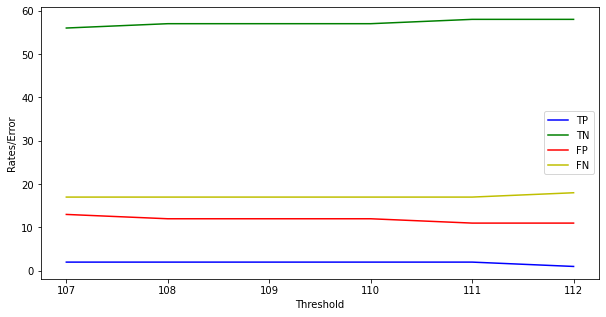

In [32]:
tp_list = results4.TP.to_list()
tn_list = results4.TN.to_list()
fp_list = results4.FP.to_list()
fn_list = results4.FN.to_list()

plt.figure(figsize=(10,5))

threshold = np.arange(107,113,1)

plt.plot(threshold,tp_list, color = 'b', label = 'TP')
plt.plot(threshold,tn_list, color = 'g', label = 'TN')
plt.plot(threshold,fp_list, color = 'r', label = 'FP')
plt.plot(threshold,fn_list, color = 'y', label = 'FN')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [33]:
data['y_tss']=''
for i in range(0,len(data)):
    if data['tss'][i] >= 111:
        data['y_tss'][i] = 'Y'
    else:
        data['y_tss'][i] = 'N'
        
data['cm_tss']=''
for k in range(0,len(data)):
    if (data['truth'][k] == 'Y') and (data['y_tss'][k] == 'Y'):
        data['cm_tss'][k] = 'TP'
    elif (data['truth'][k] == 'N') and (data['y_tss'][k] == 'Y'):
        data['cm_tss'][k] = 'FP'
    elif (data['truth'][k] == 'Y') and (data['y_tss'][k] == 'N'):
        data['cm_tss'][k] = 'FN'
    else:
        data['cm_tss'][k] = 'TN'
        
tp = data.cm_tss.value_counts().TP if 'TP' in data.cm_tss.value_counts() is not None else 0
print('true positives:',tp)
tn = data.cm_tss.value_counts().TN if 'TN' in data.cm_tss.value_counts() is not None else 0
print('true negatives:',tn)
fp = data.cm_tss.value_counts().FP if 'FP' in data.cm_tss.value_counts() is not None else 0
print('false positives:',fp)
fn = data.cm_tss.value_counts().FN if 'FN' in data.cm_tss.value_counts() is not None else 0
print('false negatives:',fn)

precision = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
print('precision:',precision)

specificity = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
print('specificity:',specificity)
    
recall = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
print('recall:',recall)   

acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
print('accuracy:',acc)

true positives: 2
true negatives: 58
false positives: 11
false negatives: 17
precision: 0.15384615384615385
specificity: 0.8405797101449275
recall: 0.10526315789473684
accuracy: 0.6818181818181818


#### cosine

In [34]:
print(max(data.cosine))
print(min(data.cosine))

0.9223059
0.5556536


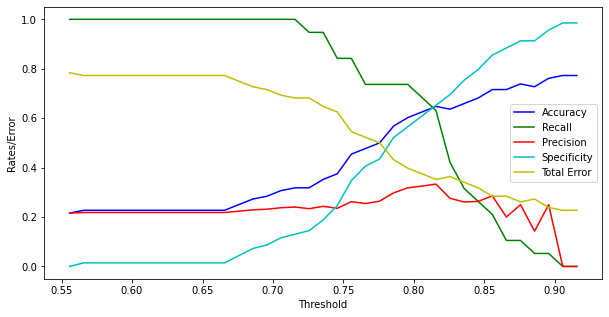

In [35]:
max_value = max(data.cosine)
min_value = min(data.cosine)
threshold = np.arange(min_value,max_value,0.01)

precision=[]
accuracy=[]
recall=[]
specificity=[]

for i in range(0,len(threshold)):
    data['y_pred'] = ''
    data['cm'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['cosine'][j] >= threshold[i]):
            data['y_pred'][j] = 'Y'
        else:
            data['y_pred'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'N'):
            data['cm'][k] = 'FN'
        else:
            data['cm'][k] = 'TN'
    
    
    tp = data.cm.value_counts().TP if 'TP' in data.cm.value_counts() is not None else 0
    tn = data.cm.value_counts().TN if 'TN' in data.cm.value_counts() is not None else 0
    fp = data.cm.value_counts().FP if 'FP' in data.cm.value_counts() is not None else 0
    fn = data.cm.value_counts().FN if 'FN' in data.cm.value_counts() is not None else 0

    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    precision.append(prec)
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    recall.append(rec)
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    accuracy.append(acc)
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    specificity.append(spec)

plt.figure(figsize=(10,5))

plt.plot(threshold, accuracy, color = 'b', label = 'Accuracy')
plt.plot(threshold, recall, color = 'g', label = 'Recall')
plt.plot(threshold, precision, color = 'r', label = 'Precision')
plt.plot(threshold, specificity, color = 'c', label = 'Specificity')
plt.plot(threshold, [1-x for x in accuracy], color = 'y', label = 'Total Error')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [55]:
threshold = np.arange(0.78,0.83,0.01)
results5 = pd.DataFrame(threshold,columns=['threshold'])
results5['TP'] = ''
results5['TN'] = ''
results5['FP'] = ''
results5['FN'] = ''

results5['specificity'] = ''
results5['recall']=''
results5['precision']=''
results5['accuracy']=''

for i in range(0,len(threshold)):
    threshold = results5['threshold'][i]
    data['y_cosine'] = ''
    data['cm_cosine'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['cosine'][j] >= threshold):
            data['y_cosine'][j] = 'Y'
        else:
            data['y_cosine'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_cosine'][k] == 'Y'):
            data['cm_cosine'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_cosine'][k] == 'Y'):
            data['cm_cosine'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_cosine'][k] == 'N'):
            data['cm_cosine'][k] = 'FN'
        else:
            data['cm_cosine'][k] = 'TN'
    
    
    tp = data.cm_cosine.value_counts().TP if 'TP' in data.cm_cosine.value_counts() is not None else 0
    results5['TP'][i] = tp
    
    tn = data.cm_cosine.value_counts().TN if 'TN' in data.cm_cosine.value_counts() is not None else 0
    results5['TN'][i] = tn
    
    fp = data.cm_cosine.value_counts().FP if 'FP' in data.cm_cosine.value_counts() is not None else 0
    results5['FP'][i] = fp
    
    fn = data.cm_cosine.value_counts().FN if 'FN' in data.cm_cosine.value_counts() is not None else 0
    results5['FN'][i] = fn
    
    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    results5['precision'][i] = prec

    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    results5['recall'][i] = rec

    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    results5['accuracy'][i] = acc 
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    results5['specificity'][i] = spec

print('---------- BERT: Cosine Similarity ----------')    
results5

---------- BERT: Cosine Similarity ----------


,threshold,TP,TN,FP,FN,specificity,recall,precision,accuracy
0,0.78,14,32,37,5,0.463768,0.736842,0.27451,0.522727
1,0.79,14,37,32,5,0.536232,0.736842,0.304348,0.579545
2,0.80,13,41,28,6,0.594203,0.684211,0.317073,0.613636
3,0.81,13,43,26,6,0.623188,0.684211,0.333333,0.636364
4,0.82,10,46,23,9,0.666667,0.526316,0.30303,0.636364


In [ ]:
data.drop(['y_pred', 'cm'], axis=1, inplace=True)
data.to_excel('bert.xlsx',index=False)